## Define Libraries and Values

In [1]:
import ipywidgets as widgets
import thinkdsp as thinkdsp
from thinkdsp import play_wave
from thinkdsp import read_wave
import math 
import wave
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/csteinmetz1/pyloudnorm
# pip install pyloudnorm
import pyloudnorm as pyln

In [2]:
Bands = 10 # Standard Band Count
Controllrange = [-12, 12, 0] # [Decrease, Gain, Default] in dB
EQBandmin = 5
EQBandmax = 20
EQstep = 5

In [3]:
Text1 = widgets.Output()
with Text1:
    print("Choose your File, that you want to edit:")
    
Text2 = widgets.Output()
with Text2:
    print("\nChoose the focus of the EQ bandpass:")
    
Text3 = widgets.Output()
with Text3:
    print("\nChoose the EQ Slider Count:")
    
Text4 = widgets.Output()
with Text4:
    print("\nEqualizer:")

In [4]:
# Generates Grid 
GraphicEQ = widgets.GridspecLayout(Bands, 1)

In [5]:
#Generates Freqspectrum for later use
Freqspecturmf0 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Displayed Frequency on EQ 
Freqspecturmfl = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Lower Frequency for EQ
Freqspecturmfh = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Higher Frequency for EQ
#if SetFilterType == 'Bass':
    #Freqspecturm = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#if SetFilterType == 'Mid':
    #Freqspecturm = [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]

## Widgets

In [6]:
# Upload a file
#Upload = widgets.FileUpload()
Upload = widgets.FileUpload(
    accept='.wav',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False,  # True to accept multiple files upload else False
    tooltips=['Upload a .wav File to Edit it']
)

In [7]:
# Choose EQ Preset
SetFilterType = widgets.ToggleButtons(
    options=['Bass', 'Mid', 'High'],
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Focus on 200Hz', 'Focus on 1kHz', 'Focus on 4kHz']
)

In [8]:
# Choose Band Count
ChooseBandCount = widgets.BoundedIntText(
    value=Bands,
    min=EQBandmin,
    max=EQBandmax,
    step=EQstep,
    disabled=False
)

## Functions

### Math Functions

In [9]:
def returnbasefreq(SetFilterType, ChooseBandCount):
    if (SetFilterType == 'Bass'):
        f_base = 20
    if (SetFilterType == 'Mid'):
        f_base = 40
    if (SetFilterType == 'High'):
        f_base = 80
    
    f_base = f_base * (8/ChooseBandCount)
        
    return f_base

In [10]:
def calculate_frequencies(SetFilterType, ChooseBandCount):
    #resets values in Freqspecturm
    Freqspecturmf0 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    # Select start frequency for calculation
    f_base = int(returnbasefreq(SetFilterType, ChooseBandCount))
    # Calculates Modulation Rate for n-Frequencies
    f_mod = pow(2, 10 / ChooseBandCount)
    
    # Generates Freqspecturm for given Type and Bandcount
    Freqspecturmf0[0] = f_base
    
    for i in range(1, ChooseBandCount+1):
        Freqspecturmf0[i] = int(f_mod * Freqspecturmf0[i-1]) # int() Rounds Value to non decimal
    
    # print (Freqspecturm)
    return Freqspecturmf0

# SetFilterType = 'Mid'
# ChooseBandCount = 20
# calculate_frequencies(SetFilterType, ChooseBandCount)

In [11]:
def calculate_frequencieslow(Freqspecturmf0, ChooseBandCount):
    # For the value of fl[0] of f0[0] we need to calculate f0[-1], fortunatly because we dont need a highpass on the first EQ we can set fl[0] = 0
    Freqspecturmfl = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    Freqspecturmfl[0] = 0
    
    for i in range(1, ChooseBandCount):
            Freqspecturmfl[i] = int(math.sqrt(Freqspecturmf0[i] * Freqspecturmf0[i-1]))
    
    return Freqspecturmfl

In [12]:
def calculate_frequencieshigh(Freqspecturmf0, ChooseBandCount):
    # For the value of fh[n] of f0[n] we need to calculate f0[n+1]
    Freqspecturmfh = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    f_mod = pow(2, 10 / ChooseBandCount)
    fnp1 = f_mod * Freqspecturmf0[ChooseBandCount]
    
    for i in range(0, ChooseBandCount):
            Freqspecturmfh[i] = int(math.sqrt(Freqspecturmf0[i] * Freqspecturmf0[i+1]))
    
    return Freqspecturmfh

### Main Interact Function

In [24]:
# Builds EQ 
def Build_Equalizer (SetFilterType, ChooseBandCount):
    # print((SetFilterType))
    # print((Bands))
    
    GraphicEQ = widgets.GridspecLayout(Bands, 1)
    
    #Calculates Freqspectrum with SetFilterType and ChooseBandCount
    Freqspecturmf0 = calculate_frequencies(SetFilterType, ChooseBandCount)
    # Calculates lower Frequencies of current Band
    FreqspecturmfLow = calculate_frequencieslow(Freqspecturmf0, ChooseBandCount)
    # Calculates Upper Frequencies of current Band
    FreqspecturmfHigh = calculate_frequencieshigh(Freqspecturmf0, ChooseBandCount)
        
    # Generates EQ and Displays Values
    slider = [widgets.IntSlider(
        value=Controllrange[2],
        min=Controllrange[0],
        max=Controllrange[1],
        step=1,
        description=str(Freqspecturmf0[i])+' Hz',
        disabled=False,
        continuous_update=False,
        orientation='vertical',
        readout=True,
        readout_format='d',
        layout = widgets.Layout(width='50%'),
    ) for i in range(int(ChooseBandCount))]
    EQDisplay = widgets.Box(children=slider)
    display(EQDisplay)
    
    
    # Edit .wav file 
    #    1.) Make [ChooseBandCount] .wav copies
    #    2.) Filter everyone of them (Bandpass with [FreqspecturmfLow, FreqspecturmfHigh] in dB
    #    3.) Combine all temp files and create output.wav
    
    with open("TempAudio.wav", "w+b") as i:
        i.write(Upload.data[0])
        
    Upload.value.clear()
    Upload._counter = 0
    
    wave = read_wave("TempAudio.wav")
    plot = wave.make_audio()
    display(plot)
    # display(FreqspecturmfLow, Freqspecturmf0, FreqspecturmfHigh)

## Display Programm Interface



In [25]:
# Combine and Format all Widgets
UserInterface = widgets.VBox(children = [Text1, Upload, Text2, SetFilterType, Text3, ChooseBandCount, Text4])
EQValues = widgets.interactive_output(Build_Equalizer, {'SetFilterType': SetFilterType, 'ChooseBandCount': ChooseBandCount})
#FilterType = widgets.interactive_output(Calculate_Frequencies, {'SetFilterType': SetFilterType})

# Outputs finished File
# spectrum = wave.make_spectrum()
# spectrum = spectrum.plot()

display(UserInterface) # User Input
display(EQValues) # Graphic Equalizer, which updates if changes are made
# display(spectrum) # Shows Plot of edited Music file
# display(wave.make_audio())

Output()

## Sources

### Programmed by Thomas Pail
    GitHub: https://github.com/Tomaru-Pai

#### Example Audio File Credits
    Song: Dimension 
    Creator: Creo 
    Youtube: https://www.youtube.com/channel/UCsCWA3Y3JppL6feQiMRgm6Q 
    Website: https://creo-music.com/track/dimension
    Licensed under: https://creativecommons.org/licenses/by/4.0/

#### Programming
    https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
    https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html
    https://en.wikibooks.org/wiki/LaTeX/Mathematics

#### Formulars and Documents for Audio
    https://www.teachmeaudio.com/mixing/techniques/audio-spectrum#upper-midrange
    https://sound.stackexchange.com/questions/14101/what-is-the-frequency-step-formula-for-10-and-31-band-eqs
    http://www.sengpielaudio.com/calculator-octave.html
    https://github.com/AllenDowney/ThinkDSP
    
#### Other Programms used
    Music editing: Audacity
    Music Download: https://github.com/yt-dlp/yt-dlp
    
#### Special Thanks
    https://www.senarclens.eu/~gerald/
    
    

<br>Upload file
<br>Split Audio into its Passes
<br>Redo if EQ Mode is changed
<br>
<br>Display EQ Sliders
<br>Combine Audio Parts back together
<br>Display Output Plots
<br>Dispay finished file

## TestArea

In [15]:
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [16]:
x_widget = widgets.FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = widgets.FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
widgets.interact(printer,x=x_widget, y=y_widget);

interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, step=0.05), FloatSlider(value=5.0, des…

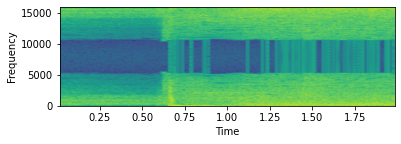

In [17]:
import wave
import numpy as np
import matplotlib.pyplot as plt

signal_wave = wave.open('Example_Creo_Dimension.wav', 'r')
sample_rate = 32000
sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

sig = sig[:]

plt.figure(1)

plot_b = plt.subplot(212)
plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
plot_b.set_xlabel('Time')
plot_b.set_ylabel('Frequency')

plt.show()

## Formulars and Notes

For 10 Band EQ
$
f1 = lowerband
\newline
f0 = Baseband
\newline
f2 = upperband
\newline
f1 = \frac{f2}{2} = 0,5 * f2
\newline
f2 = 2 * f1
\newline
f0 = \sqrt{f1*f2} = \sqrt{2} * f1
\newline
f1 - f2 = I * f0 = 
\newline
I = (\sqrt{2} - \frac{1}{\sqrt{2}}) = \frac{\sqrt{2}}{2} = 0.707106781
$

10^((n+12)/10)

## ToDoList

In [18]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [19]:
with open("TempAudio.wav", "w+b") as i:
    i.write(upload.data[0])

IndexError: list index out of range

In [ ]:
from pydub import AudioSegment

song = AudioSegment.from_wav("Example_Creo_Dimension.wav")

# but let's make him *very* quiet
song_10_db_quieter = song - 6

# save the output
song_10_db_quieter.export("TempAudio.wav", "wav")

wave2 = read_wave('Example_Creo_Dimension.wav')
disp1 = wave2.make_audio()
wave = read_wave('TempAudio.wav')
disp2 = wave.make_audio()

display(disp1, disp2)

In [ ]:

import wave, audioop

factor = 0.01

with wave.open('Example_Creo_Dimension.wav', 'rb') as wav:
    p = wav.getparams()
    with wave.open('Test.wav', 'wb') as audio:
        audio.setparams(p)
        frames = wav.readframes(p.nframes)
        audio.writeframesraw( audioop.mul(frames, p.sampwidth, factor))

wave2 = read_wave('Example_Creo_Dimension.wav')
disp1 = wave2.make_audio()
wave = read_wave('TempAudio.wav')
disp2 = wave.make_audio()

display(disp1, disp2)

In [ ]:
import soundfile as sf
import pyloudnorm as pyln
from pydub import AudioSegment

modulation = -12


data, rate = sf.read("Example_Creo_Dimension.wav") # load audio (with shape (samples, channels))
print(data.shape)
meter = pyln.Meter(rate) # create BS.1770 meter
loudness = meter.integrated_loudness(data) # measure loudness
print(loudness)
# loudness normalize audio to -12 dB LUFS
loudness_normalized_audio = pyln.normalize.loudness(data, loudness, -12)
sf.write("TempAudio.wav", loudness_normalized_audio, rate)

song = AudioSegment.from_wav("TempAudio.wav")

# but let's make him *very* quiet
song_10_db_quieter = song + modulation

# save the output
song_10_db_quieter.export("TempAudio.wav", "wav")


### Installation Notes

In [ ]:
a = widgets.IntSlider(description="Delayed", continuous_update=False)
b = widgets.IntText(description="Delayed", continuous_update=False)
c = widgets.IntSlider(description="Continuous", continuous_update=True)
d = widgets.IntText(description="Continuous", continuous_update=True)

widgets.link((a, 'value'), (b, 'value'))
widgets.link((a, 'value'), (c, 'value'))
widgets.link((a, 'value'), (d, 'value'))
widgets.VBox([a,b,c,d])

In [ ]:
# Value is the dB Value that the file will be normalised with
# void function: Overrides [FileName] File

FileName = "Upload.wav" # Name of saved uploaded file

def Normalise_Audio (FileName, Normalise):
    # Load Audio File as shape(data, wave)
    data, rate = sf.read(FileName)

    # Initiolising loudness Meter by BS.1770 standart 
    meter = pyln.Meter(rate) 
    # measure loudness in dB
    loudness = meter.integrated_loudness(data)
    
    # loudness normalize audio to [Normalise] dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(data, loudness, Normalise)
    sf.write(FileName, loudness_normalized_audio, rate)

In [ ]:
# Overwrites [n] temp Audio File
# Filename is the current edited Bandpass
# Gain is the current used Gain value of said bandpass

def Bandpass_Filter (FileName, n, Gain, fl, fh):
    # Load Audio File
    wave = read_wave(FileName + string(n) + ".wav")
    # Lowpass filter with fh
    spectrum.low_pass(fh)
    # Highpass filter with fl
    spectrum.high_pass(fl)
    # Overrides Temp Audio File
    with open(FileName + string(n) + ".wav", "w+b") as edit:
        edit.write(wave)

In [ ]:
# Overlaps several AudioFiles which have the same base name + and adressing Number + ".wav"
# Example "FilterTemp" + string(n) + ".wav" starting from 0 to Bandpasscount-1
# FileName must not contail ".wav" !!!
# FileType is the file ending, for example ".wav"
# FinishedFileName is the Filename which the Audio will be saved. Must contain Filename+".wav"

def Build_Audio (FileName, BandpassCount, FileType, FinishedFileName):
    # Load first Adio file
    fullaudio = AudioSegment.from_wav(FileName + "0" + FileType)
    # Generates loop
    for i in range(0, ChooseBandCount-1):
        # import current file
        temp = AudioSegment.from_wav(FileName + string(ChooseBandCount) + ".wav")
        # Overlays fullaudio with new generated wave file
        fullaudio = fullaudio.overlay(temp)

    # Saves fullaudio
    fullaudio.export(FinishedFileName, ".wav")
    
    
    # Deletes temp Files (optional)

In [ ]:
# Generates Temp Copies for Processing every single Band
# File Name is the UploadFile Name
# FileName must not contail ".wav" !!!

def Generate_Copies(FileName, BandpassCount):
    for i in range(0, ChooseBandCount-1):
        FileName.export(FinishedFileName + string(ChooseBandCount) + ".wav", "wav")

In [ ]:
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
from scipy.signal import butter, sosfilt, sosfreqz

wave = wavfile.read('Example_Creo_Dimension.wav')
# wave = wavfile.read('Example_Creo_Dimension.wav')

def butter_bandpass(lowcut, highcut, fs, order = 5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    
wave2 = butter_bandpass_filter(wave, 1000, 2000, 48000, 5)